In [ ]:
from openqaoa import QAOA
from openqaoa.problems import Knapsack
import numpy as np
#import method to specify the device
from openqaoa.backends import create_device
# import the OpenQAOA Parameterisation classes manually: Manual Mode
from openqaoa.qaoa_components import (PauliOp, Hamiltonian, QAOADescriptor,
create_qaoa_variational_params, QAOAVariationalStandardParams, QAOAVariationalExtendedParams)
from openqaoa.optimizers import get_optimizer
# import the other OpenQAOA modules required for this example
from openqaoa.utilities import X_mixer_hamiltonian
from openqaoa.backends.qaoa_backend import get_qaoa_backend
# Knapsack Problem Parameters
n = 4  # Number of variables
values = [10, 15, 40, 30]  # Item values
weights = [2, 3, 5, 7]  # Item weights
capacity = 10  # Knapsack capacity
penalty_strength = 100  # Penalty multiplier for all methods
# Define your terms and coefficients
terms = [PauliOp('Z', [0]), PauliOp('Z', [1]), PauliOp('ZZ', [0, 1])]
coeffs = [1.0, 1.0, 0.5]
constant = 0.0



1.0*Z_{0} + 1.0*Z_{1} + 0.5*Z_{0}Z_{1} + 0.0


Method: hybrid
  Result: {'solutions_bitstrings': ['0010'], 'bitstring_energy': -15.0}



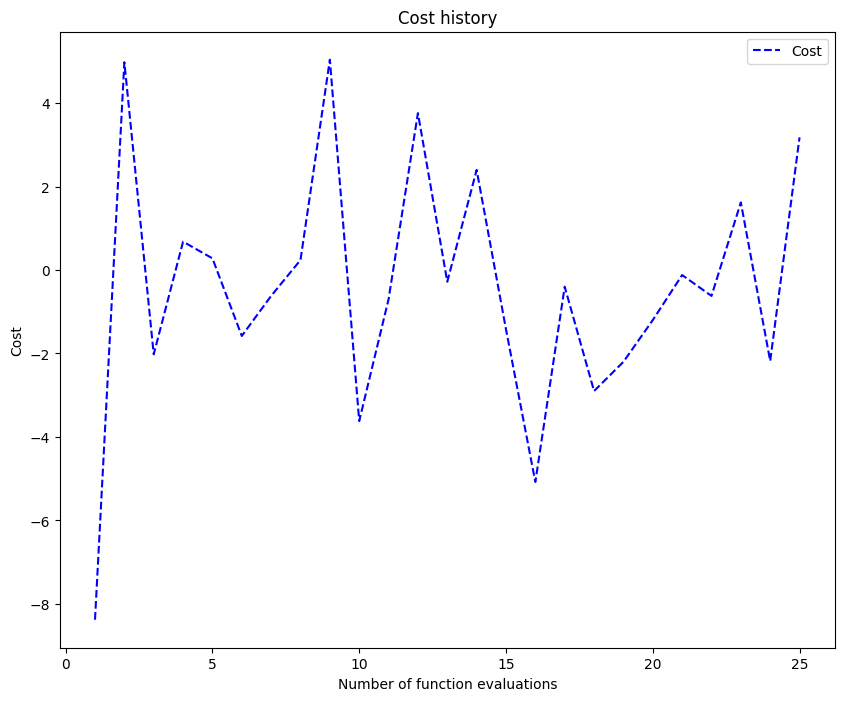

In [32]:
import datetime

# Knapsack Problem Parameters
n = 4  # Number of variables
values = [10, 15, 40, 30]  # Item values
weights = [2, 3, 5, 7]  # Item weights
capacity = 10  # Knapsack capacity
penalty_strength = 100  # Penalty multiplier for all methods

def hybrid_penalty(weights, capacity, penalty_strength):
    """
    Creates a Hamiltonian penalty for the hybrid method without slack variables.

    Returns
    -------
    Hamiltonian
        The penalty Hamiltonian for the hybrid method.
    """
    pauli_terms = []
    coefficients = []

    for i in range(n):
        for j in range(n):
            if i != j:
                pauli_terms.append(PauliOp('ZZ', [i, j]))  # Interaction term
                coefficients.append(
                    penalty_strength * weights[i] * weights[j] / (capacity**2)
                )
        pauli_terms.append(PauliOp('Z', [i]))  # Linear term
        coefficients.append(
            penalty_strength * weights[i] * (capacity - weights[i]) / capacity
        )

    return Hamiltonian(pauli_terms, coefficients, constant=0.0)

def define_qaoa_problem(method="hybrid"):
    """
    Define the QAOA Hamiltonian based on the selected penalty method.

    Returns
    -------
    qaoa : QAOA
        QAOA instance for solving the problem.
    """
    # Objective Hamiltonian (maximize value)
    objective_terms = [PauliOp('Z', [i]) for i in range(n)]
    coefficients = [-values[i] for i in range(n)]  # Negative because OpenQAOA minimizes
    objective_hamiltonian = Hamiltonian(objective_terms, coefficients, constant=0.0)

    # Constraint Hamiltonian
    if method == "slack":
        # Add slack variables explicitly as qubits
        slack_terms = [PauliOp('Z', [i]) for i in range(n)]
        slack_coeffs = [penalty_strength * weights[i] for i in range(n)]
        mix_hamiltonian = Hamiltonian(slack_terms, slack_coeffs, constant=0.0)

    elif method == "unbalanced":
        # Unbalanced penalty method
        unbalanced_terms = [PauliOp('Z', [i]) for i in range(n)]
        unbalanced_coeffs = [
            -penalty_strength * weights[i] + penalty_strength * (weights[i] ** 2)
            for i in range(n)
        ]
        mix_hamiltonian = Hamiltonian(unbalanced_terms, unbalanced_coeffs, constant=0.0)

    elif method == "hybrid":
        # Hybrid penalty method
        mix_hamiltonian = hybrid_penalty(weights, capacity, penalty_strength)

    # Create QAOA instance
    qaoa = QAOA()
    device_local = create_device(location='local', name='qiskit.shot_simulator')
    qaoa_descriptor = QAOADescriptor(cost_hamiltonian = objective_hamiltonian, mixer_block = mix_hamiltonian, p=1)
    backend_local = get_qaoa_backend(qaoa_descriptor, device_local, n_shots=500)
    #To create a Variational Parameter Class with the Standard Parameterisation and Random Initialisation
    variate_params = create_qaoa_variational_params(qaoa_descriptor = qaoa_descriptor, params_type = 'standard', init_type = 'rand')
    optimizer = get_optimizer(backend_local, variate_params, {'method': 'cobyla',
                                                          'maxiter': 100})

    return optimizer

def benchmark(method):
    """
    Benchmark a specific method for solving the knapsack problem.

    Returns
    -------
    result : dict
        Results of the QAOA run, including bitstring and objective value.
    """
    # Define the QAOA problem
    qaoa = define_qaoa_problem(method)
    # qaoa.compile()
    # Run QAOA
    qaoa.optimize()
    # result = qaoa.get_results()
    result = qaoa.qaoa_result.most_probable_states
    opt_results = qaoa.qaoa_result
    # print the cost history
    fig, ax = opt_results.plot_cost()
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    fig.savefig(f"out/cost_history_{method}_{current_time}.png")
    # Analyze the solution
    # bitstring = result["solutions_bitstrings"]
    # objective_value = sum(
    #     bitstring[i] * values[i] for i in range(len(bitstring))
    # )  # Objective value
    # total_weight = sum(
    #     bitstring[i] * weights[i] for i in range(len(bitstring))
    # )  # Total weight
    
    return {
        "method": method,
        "result": result,
        # "objective_value": objective_value,
        # "constraint_satisfied": total_weight <= capacity,
    }

# Benchmarking
methods = ["slack", "unbalanced", "hybrid"]
methods = ["hybrid"]
results = []
for method in methods:
    res = benchmark(method)
    results.append(res)

# Print Results
for r in results:
    print(f"Method: {r['method']}")
    print(f"  Result: {r['result']}")
    # print(f"  Optimal Bitstring: {r['bitstring']}")
    # print(f"  Objective Value: {r['objective_value']}")
    # print(f"  Constraint Satisfied: {r['constraint_satisfied']}")
    print()
